## Set-up

In [ ]:
from google.colab import drive, files
drive.mount('drive')

In [ ]:
import os
import glob
import time
import datetime
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Input

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.models import load_model

In [ ]:
class DeepEnsemble():
    @staticmethod
    def load_from_dir(directory, **kwargs):
      new = DeepEnsemble(**kwargs)
      models = []
      print(list(os.walk(directory)))
      for path in list(os.walk(directory))[0][1]:
          temp_model = []
          temp_model.append(load_model(os.path.join(directory, path, "training")))
          temp_model.append(load_model(os.path.join(directory, path, "encoder")))
          temp_model.append(load_model(os.path.join(directory, path, "decoder")))

          models.append(tuple(temp_model))

      new.models = models
      return new

    def __init__(self, no_models=5, threshold=0.8, name=None):
        self.no_models = no_models
        self.models = [self.Seq2SeqModel() for i in range(self.no_models)]
        self.threshold=threshold

        now = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
        self.name = name if name else f"DeepEnsemble_{now}"

    def fit(self, **kwargs):
        if kwargs.get("verbose") is None:
            kwargs["verbose"] = 1
        for i in range(self.no_models):
            print(f"Training model no. {i+1}")
            self.models[i][0].fit(**kwargs)

    def predict(self, X):
        # Encode the sequence for the models
        input_seq = self.encode_for_inference(X)

        # No. of remaining models to run
        remaining =  self.no_models

        # No. of matching predictions required
        k = self.threshold * self.no_models

        predictions = {}
        for i in self.models:
            out = self.decode_sequence(i[1], i[2], input_seq)
            predictions[out] = predictions.get(out, 0) + 1
            remaining -= 1

            if max(predictions.values()) + remaining < k:
              return X

            elif max(predictions.values()) >= k:
              return max(predictions, key=predictions.get)

        return X

    def save(self, save_dir=None):
        if save_dir == None:
            save_dir = self.name
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        folder_names = [os.path.join(save_dir, f"model_{i+1}") for i in range(self.no_models)]

        for i, path in enumerate(folder_names):
            if not os.path.exists(path):
                os.makedirs(path)

            self.models[i][0].save(os.path.join(path, f'training'))
            self.models[i][1].save(os.path.join(path, f'encoder'))
            self.models[i][2].save(os.path.join(path, f'decoder'))

    def encode_for_inference(self, input_text):
        encoder_input_text = np.zeros(
            (1, max_encoder_seq_length, num_encoder_tokens), dtype="float32"
        )
        for t, char in enumerate(input_text):
            encoder_input_text[:, t, input_token_index[char]] = 1.0
        encoder_input_text[:, t + 1 :, input_token_index[" "]] = 1.0
        return encoder_input_text

    def Seq2SeqModel(self):
        # Define an input sequence and process it.
        encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
        encoder = keras.layers.LSTM(latent_dim, return_state=True)
        encoder_outputs, state_h, state_c = encoder(encoder_inputs)

        # We discard `encoder_outputs` and only keep the states.
        encoder_states = [state_h, state_c]

        # Set up the decoder, using `encoder_states` as initial state.
        decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

        # We set up our decoder to return full output sequences,
        # and to return internal states as well. We don't use the
        # return states in the training model, but we will use them in inference.
        decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
        decoder_outputs = decoder_dense(decoder_outputs)

        # Define the model that will turn
        # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
        model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
        )

        encoder_inputs = model.input[0]  # input_1
        encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
        encoder_states = [state_h_enc, state_c_enc]
        encoder_model = keras.Model(encoder_inputs, encoder_states)

        decoder_inputs = model.input[1]  # input_2
        decoder_state_input_h = keras.Input(shape=(latent_dim,))
        decoder_state_input_c = keras.Input(shape=(latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        decoder_lstm = model.layers[3]
        decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
            decoder_inputs, initial_state=decoder_states_inputs
        )
        decoder_states = [state_h_dec, state_c_dec]
        decoder_dense = model.layers[4]
        decoder_outputs = decoder_dense(decoder_outputs)
        decoder_model = keras.Model(
            [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
        )

        return (model, encoder_model, decoder_model)

    def decode_sequence(self, encoder_model, decoder_model, input_seq):
        # Encode the input as state vectors.
        states_value = encoder_model.predict(input_seq)

        # Generate empty target sequence of length 1.
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        # Populate the first character of target sequence with the start character.
        target_seq[0, 0, target_token_index["\t"]] = 1.0

        # Sampling loop for a batch of sequences
        # (to simplify, here we assume a batch of size 1).
        stop_condition = False
        decoded_sentence = ""
        while not stop_condition:
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

            # Sample a token
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_char = reverse_target_char_index[sampled_token_index]
            decoded_sentence += sampled_char

            # Exit condition: either hit max length
            # or find stop character.
            if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
                stop_condition = True

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1, 1, num_decoder_tokens))
            target_seq[0, 0, sampled_token_index] = 1.0

            # Update states
            states_value = [h, c]

        return decoded_sentence

## Data

In [ ]:
df = pd.read_csv("drive/MyDrive/ailab/data/spell_correction_doccano/sc_fb_2022-08-15.csv")
df.drop(['id'], axis=1, inplace=True)
df.dropna(inplace=True)
df.shape

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples=33000

In [ ]:
val_data = df.iloc[num_samples:,:]
model_data = df.iloc[:num_samples,:]

In [ ]:
data_path = 'output.txt'
model_data.to_csv(data_path, header=None, index=None, sep=',', mode='w')

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    try:
        input_text, target_text = line.split(',')
    except ValueError:
        continue
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
input_characters.insert(0, ' ')
target_characters = sorted(list(target_characters))
target_characters.insert(0, ' ')

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0


In [ ]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [ ]:
import json

#with open('reverse_input_char_index.json', 'w') as fp:
#    json.dump(reverse_input_char_index, fp)

#with open('reverse_target_char_index.json', 'w') as fp:
#    json.dump(reverse_target_char_index, fp)

with open('input_token_index.json', 'w') as fp:
    json.dump(input_token_index, fp)

with open('target_token_index.json', 'w') as fp:
    json.dump(target_token_index, fp)

files.download('target_token_index.json')
files.download('input_token_index.json')

#loaded_r = json.loads(r)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

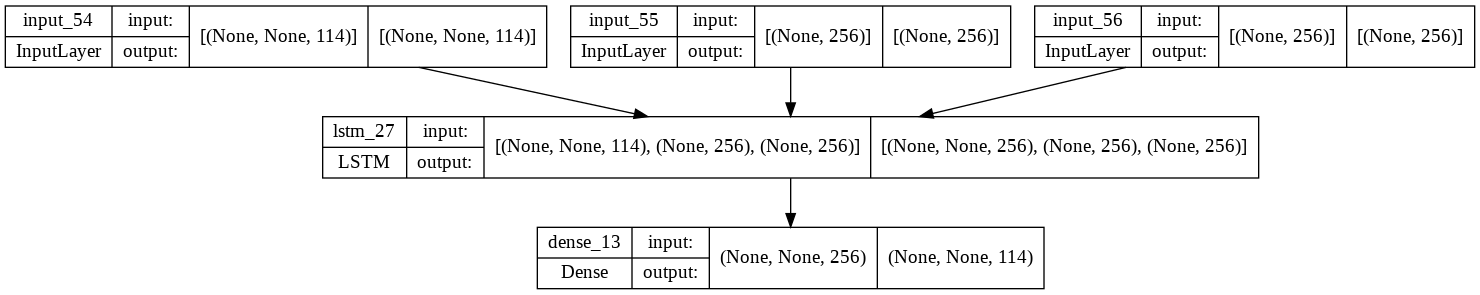

In [ ]:
from tensorflow.keras.utils import plot_model

de = DeepEnsemble(no_models=5, threshold=0.8)
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5)
]

plot_model(de.models[0][0], show_shapes=True, to_file='model.png')
plot_model(de.models[0][1], show_shapes=True, to_file='encoder.png')
plot_model(de.models[0][2], show_shapes=True, to_file='decoder.png')

In [ ]:
de = DeepEnsemble(no_models=5, threshold=0.8)
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5)
]

history = de.fit(
    x=[encoder_input_data, decoder_input_data],
    y=decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks
)

In [ ]:
save_path = "drive/MyDrive/ailab/spell_correction/models/DE_v3"
if not os.path.exists(save_path):
    de.save("drive/MyDrive/ailab/spell_correction/models/DE_v3")

## Load the model

In [ ]:
load_path = "drive/MyDrive/DE_v3_"
myde = DeepEnsemble.load_from_dir(load_path)

[('drive/MyDrive/DE_v3_', ['model_5', 'model_2', 'model_3', 'model_1', 'model_4'], []), ('drive/MyDrive/DE_v3_/model_5', ['encoder', 'decoder', 'training'], []), ('drive/MyDrive/DE_v3_/model_5/encoder', ['variables'], ['keras_metadata.pb', 'saved_model.pb']), ('drive/MyDrive/DE_v3_/model_5/encoder/variables', [], ['variables.index', 'variables.data-00000-of-00001']), ('drive/MyDrive/DE_v3_/model_5/decoder', ['variables'], ['saved_model.pb', 'keras_metadata.pb']), ('drive/MyDrive/DE_v3_/model_5/decoder/variables', [], ['variables.data-00000-of-00001', 'variables.index']), ('drive/MyDrive/DE_v3_/model_5/training', ['variables'], ['keras_metadata.pb', 'saved_model.pb']), ('drive/MyDrive/DE_v3_/model_5/training/variables', [], ['variables.index', 'variables.data-00000-of-00001']), ('drive/MyDrive/DE_v3_/model_2', ['training', 'decoder', 'encoder'], []), ('drive/MyDrive/DE_v3_/model_2/training', ['variables'], ['keras_metadata.pb', 'saved_model.pb']), ('drive/MyDrive/DE_v3_/model_2/training

In [ ]:
myde.no_models=3
myde.models = myde.models[:3]
myde.threshold = 0.66

In [ ]:
myde.predict("getdim")

'getdim\n'

In [ ]:
chars = reverse_target_char_index.values()
val_data.dropna(inplace=True)
val_data = val_data[val_data["text"].apply(lambda s: all(c in chars for c in s))]
val_data = val_data[val_data['text'].str.len() <= model_data['text'].str.len().max()]
output = []
start = time.time()
for i, row in enumerate(val_data["text"]):
    pred = myde.predict(row)
    output.append(pred.strip(' \n\r\t'))
    if i % 25 == 0:
      print(i)

end = time.time()
duration = end - start
val_data['prediction'] = output

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950


In [ ]:
def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2

    a = 0
    b = 0
    c = 0

    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]

                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

In [ ]:
def plot(data):
  data['distance']=[levenshteinDistanceDP(i, t) for i,t in zip(list(data['label']), list(data['prediction']))]
  data[data['distance']==0].shape[0] /  data.shape[0]
  data['org']=[levenshteinDistanceDP(i, t) for i,t in zip(list(data['label']), list(data['text']))]
  length = data.shape[0]
  org_points = [data[data['org']==0].shape[0] / length, data[data['org']<=1].shape[0] / length, data[data['org']<=2].shape[0] / length, data[data['org']<=3].shape[0] / length]
  pred_points = [data[data['distance']==0].shape[0] / length, data[data['distance']<=1].shape[0] / length, data[data['distance']<=2].shape[0] / length, data[data['distance']<=3].shape[0] / length]
  print(list(map(lambda x: round(x, 3), org_points)))
  print(list(map(lambda x: round(x, 3), pred_points)))
  x = range(4)

  fig, ax1 = plt.subplots()

  ax2 = ax1.twinx()
  ax3 = ax2.twinx()
  ax1.plot(x, org_points, 'g-')
  ax2.plot(x, pred_points, 'b-')
  ax3.plot(x, np.array(pred_points) - np.array(org_points), 'r--')

  ax1.set_xlabel('X data')
  ax1.set_ylabel('Y1 data', color='g')
  ax2.set_ylabel('Y2 data', color='b')
  ax3.set_ylabel('Y3 data', color='r')

  ax1.set_ylim(0, 1)
  ax2.set_ylim(0, 1)
  ax3.set_ylim(0, 1)

  plt.show()

[0.6, 0.831, 0.926, 0.976]
[0.856, 0.96, 0.978, 0.992]


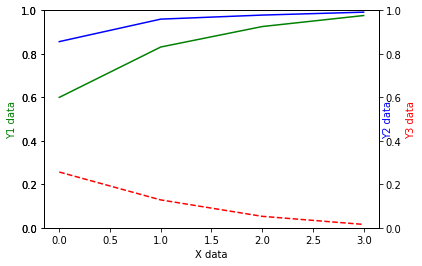

In [ ]:
plot(val_data)

In [ ]:
avg = (end - start) / len(val_data["text"])

In [ ]:
avg_char = avg / val_data["text"].str.len().mean()

In [ ]:
print(avg, avg_char)

0.9248637672294135 0.1230014114854687


In [ ]:
val_0_dif = val_data[val_data["org"] == 0]
val_1_dif = val_data[val_data["org"] == 1]
val_2_dif = val_data[val_data["org"] == 2]
val_3_dif = val_data[val_data["org"] >= 3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[1.0, 1.0, 1.0, 1.0]
[0.941, 0.993, 1.0, 1.0]


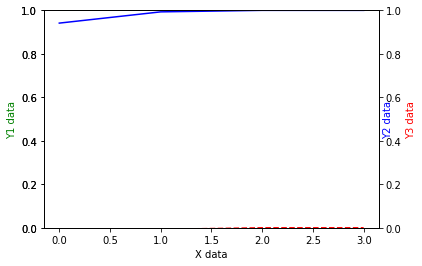

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[0.0, 1.0, 1.0, 1.0]
[0.763, 0.978, 1.0, 1.0]


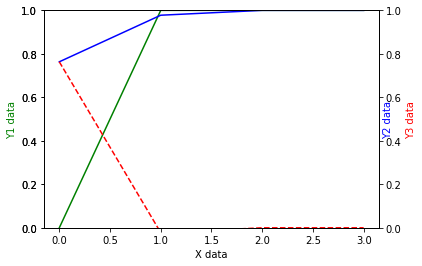

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[0.0, 0.0, 1.0, 1.0]
[0.747, 0.89, 0.989, 1.0]


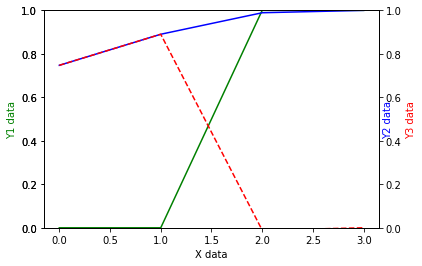

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[0.0, 0.0, 0.0, 0.681]
[0.597, 0.722, 0.722, 0.889]


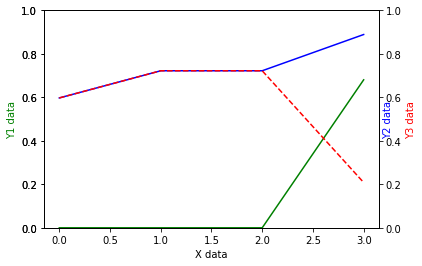

In [ ]:
plot(val_0_dif)
plot(val_1_dif)
plot(val_2_dif)
plot(val_3_dif)

In [ ]:
val_0_5 = val_data[val_data["text"].str.len() < 5]
val_5_8 = val_data[(5<=val_data["text"].str.len())&(val_data["text"].str.len()< 9)]
val_8_12 = val_data[(9<=val_data["text"].str.len())&(val_data["text"].str.len()< 13)]
val_13 = val_data[val_data["text"].str.len() >=13]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[0.535, 0.837, 0.988, 1.0]
[0.884, 0.942, 1.0, 1.0]


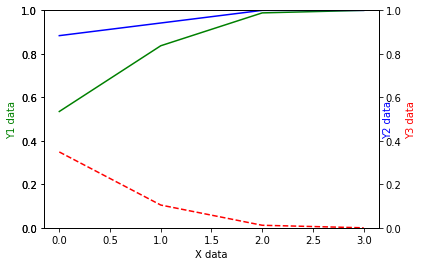

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[0.602, 0.855, 0.943, 0.984]
[0.874, 0.972, 0.986, 0.993]


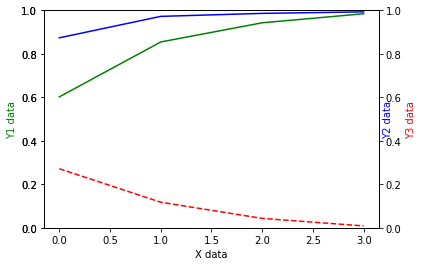

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[0.623, 0.784, 0.873, 0.951]
[0.832, 0.944, 0.959, 0.985]


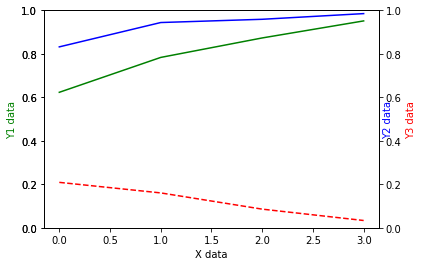

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[0.543, 0.8, 0.886, 0.971]
[0.686, 0.914, 0.943, 1.0]


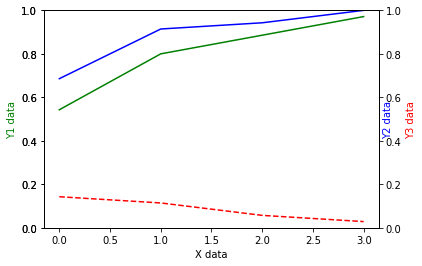

In [ ]:
plot(val_0_5)
plot(val_5_8)
plot(val_8_12)
plot(val_13)